In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp

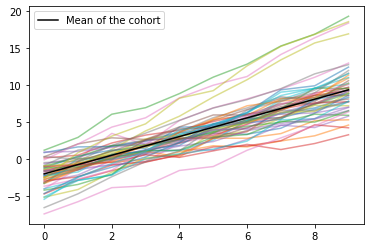

In [34]:
#Exercise 1
#2)

#Parameters
t0_mean = 2
v0_mean = 1
sigma2_xi = 0.1
sigma2_tau = 1
sigma2 = 0.5

p0 = 0
sigma2_t0 = 0.2
sigma2_v0 = 0.2

N = 50
t = np.arange(0,10) #I chose that all the individuals get measured at the same time

#Computation of z
t0 = np.random.normal(t0_mean,sigma2_t0)
v0 = np.random.normal(v0_mean,sigma2_v0)

xi = sp.multivariate_normal.rvs(mean=np.zeros(N),cov=np.diag([sigma2_xi]*N))
tau = sp.multivariate_normal.rvs(mean=np.zeros(N),cov=np.diag([sigma2_tau]*N))

#Generating the samples
def d(time):
    return p0 + v0*(time-t0)

y = np.zeros((N,t.shape[0]))

for i in range(N):
    for j in range(t.shape[0]):
        y[i,j] = d(np.exp(xi[i])*(t[j] - t0 - tau[i]) + t0) + np.random.normal(0,sigma2)

#Plotting
for data in y:
    plt.plot(t,data,alpha=0.5)

plt.plot(t,d(t),color="black",label="Mean of the cohort")
plt.legend()
plt.show()

In [35]:
#B)
def HM_sampling(density,maxIter,z0):
    if isinstance(z0, np.ndarray):
        sigma2_prop = np.eye(z0.shape[0])*0.0001
    else:
        sigma2_prop = 0.0001
    
    z = z0
    
    for k in range(1,maxIter):
        #Proposal
        z_star = sp.multivariate_normal.rvs(mean=z,cov=sigma2_prop)
        
        if (np.random.uniform() < min(1,density(z_star)/density(z))):
            z = z_star
    return z

In [36]:
#4)
def SAEM(y,theta0,maxIter,burn_in,sampler):
    N = y.shape[0]
    
    theta = theta0 #[t0_mean,v0_mean,sigma2_xi,sigma2_tau,sigma2]
    z = np.zeros(2 + 2*N) #z = [t0, v0, xi_1, tau_1, ...]
    S = np.zeros(5)
    
    for k in range(maxIter):
        #Simulation
        z = sampler(z,y,theta)
        
        #Stochastic approximation
        #First computing the d_ij will be convenient for after
        dij = np.zeros((N,t.shape[0]))
        d = lambda time: p0 + z[1]*(time-z[0])
            
        for i in range(N):
            d_i = lambda t_ij : d(np.exp(z[2 + 2*i])*(t_ij - z[0] - z[3 + 2*i]) + z[0])
            
            for j in range(t.shape[0]): #For the y_ij
                dij[i,j] = d_i(t[j])
        
        #S(y,z)
        new_S = np.zeros(5)
        new_S[0] = np.sum([[(y[i,j]-dij[i,j])**2 for j in range(t.shape[0])] for i in range(N)])
        new_S[1] = np.sum([z[2 + 2*i]**2 for i in range(N)])
        new_S[2] = np.sum([z[3 + 2*i]**2 for i in range(N)])
        new_S[3] = z[0]
        new_S[4] = z[1]
        
        if (k <= burn_in):
            epsilon_k = 1
        else:
            (k-burn_in)**(-0.9)
            
        S += epsilon_k*(new_S - S)

        #Maximisation
        theta[0] = S[3]
        theta[1] = S[4]
        theta[2] = S[1]/N
        theta[3] = S[2]/N
        theta[4] = S[0]/(N*t.shape[0])
        
    return theta,z

In [37]:
def HM_sampler_for_SAEM(z0,y,theta):
    def a_posterior_ratio(z):
        #Distribution used in the ratio for sampling the a posteriori
        #z = [t0, v0, xi_1, tau_1, ...]
        res = 0
        
        #For z_pop
        res -= (z[0] - theta[0])**2/sigma2_t0
        res -= (z[1] - theta[1])**2/sigma2_v0
        
        #For the y_ij
        d = lambda time: p0 + z[1]*(time-z[0])
        
        for i in range(N):
            for j in range(t.shape[0]):
                d_i = lambda t_ij : d(np.exp(z[2 + 2*i])*(t_ij - z[0] - z[3 + 2*i]) + z[0])
                res -= (y[i,j] - d_i(t[j]))**2/theta[4]
                
            #For the z_i
            res -= z[2 + 2*i]**2/theta[2]
            res -= z[3 + 2*i]**2/theta[3]
        return np.exp(res/2)
    return HM_sampling(a_posterior_ratio,75,z0)

In [38]:
theta,z = SAEM(y,np.ones(5),300,150,HM_sampler_for_SAEM)
real_theta = [t0_mean,v0_mean,sigma2_xi,sigma2_tau,sigma2]

print("The estimated theta is :")
print(theta)

print("The real theta is :")
print(real_theta)

print("The distance between the real xi and the estimated ones is %f"%np.linalg.norm(z[2::2]-xi))
print("The distance between the real tau and the estimated ones is %f"%np.linalg.norm(z[3::2]-tau))

<ipython-input-35-54add1a27b87>:14: RuntimeWarning: invalid value encountered in double_scalars
  if (np.random.uniform() < min(1,density(z_star)/density(z))):


The estimated theta is :
[1.73188229 1.36303922 0.12806978 1.18465708 0.30137968]
The real theta is :
[2, 1, 0.1, 1, 0.5]
The distance between the real xi and the estimated ones is 0.733594
The distance between the real tau and the estimated ones is 2.503423


In [39]:
#C)
#7) Essentially the same thing, the sampling will just be done one parameter at a time
def Gibbs_sampler_for_SAEM(z0,y,theta):
    z = np.zeros(z0.shape)
    z[:] = z0[:]
    
    #We start with the z_i
    #We start with xi_i
    for i in range(N):
        def a_posterior_ratio(x):
            #Distribution used in the ratio for sampling the a posteriori
            #x is z = xi_i
            res = 0
            res -= x**2/theta[2]

            d = lambda time: p0 + z[1]*(time-z[0])
            d_i = lambda t_ij : d(np.exp(x)*(t_ij - z[0] - z[3 + 2*i]) + z[0])

            for j in range(t.shape[0]): #For the y_ij
                res -= (y[i,j] - d_i(t[j]))**2/theta[4]

            return np.exp(res/2)

            z[2 + 2*i] = HM_sampling(a_posterior_ratio,75,z[2 + 2*i])

    #Now tau_i
    for i in range(N):
        def a_posterior_ratio(x):
            #Distribution used in the ratio for sampling the a posteriori
            #x is tau_i
            res = 0
            res -= x**2/theta[3]

            d = lambda time: p0 + z[1]*(time-z[0])
            d_i = lambda t_ij : d(np.exp(z[2 + 2*i])*(t_ij - z[0] - x) + z[0])

            for j in range(t.shape[0]): #For the y_ij
                res -= (y[i,j] - d_i(t[j]))**2/theta[4]

            return np.exp(res/2)

        z[3 + 2*i] = HM_sampling(a_posterior_ratio,75,z[3 + 2*i])

    #Now it's time for z_pop
    #First t0
    def a_posterior_ratio(x):
        #Distribution used in the ratio for sampling the a posteriori
        #x is t0
        res = 0
        res -= (x-theta[0])**2/sigma2_t0

        d = lambda time: p0 + z[1]*(time-x)

        for i in range(N):
            for j in range(t.shape[0]): #For the y_ij
                d_i = lambda t_ij : d(np.exp(z[2 + 2*i])*(t_ij - x - z[3 + 2*i]) + x)
                res -= (y[i,j] - d_i(t[j]))**2/theta[4]

        return np.exp(res/2)

    z[0] = HM_sampling(a_posterior_ratio,75,z[0])

    #Finally v0
    def a_posterior_ratio(x):
        #Distribution used in the ratio for sampling the a posteriori
        #x is v0
        res = 0
        res - (x-theta[1])**2/sigma2_v0

        d = lambda time: p0 + x*(time-z[0])

        for i in range(N):
            for j in range(t.shape[0]): #For the y_ij
                d_i = lambda t_ij : d(np.exp(z[2 + 2*i])*(t_ij - z[0] - z[3 + 2*i]) + z[0])
                res -= (y[i,j] - d_i(t[j]))**2/theta[4]

        return np.exp(res/2)

    z[1] = HM_sampling(a_posterior_ratio,75,z[1])

    return z

In [44]:
theta,z = SAEM(y,np.ones(5),600,300,Gibbs_sampler_for_SAEM)
real_theta = [t0_mean,v0_mean,sigma2_xi,sigma2_tau,sigma2]

print("The estimated theta is :")
print(theta)

print("The real theta is :")
print(real_theta)

print("The distance between the real xi and the estimated ones is %f"%np.linalg.norm(z[2::2]-xi))
print("The distance between the real tau and the estimated ones is %f"%np.linalg.norm(z[3::2]-tau))

<ipython-input-35-54add1a27b87>:14: RuntimeWarning: invalid value encountered in double_scalars
  if (np.random.uniform() < min(1,density(z_star)/density(z))):


The estimated theta is :
[1.76805617 1.33783512 0.         2.09389921 1.88673548]
The real theta is :
[2, 1, 0.1, 1, 0.5]
The distance between the real xi and the estimated ones is 2.453873
The distance between the real tau and the estimated ones is 6.896056


In [41]:
#9) Again the same thing, just z_pop and z_i done in blocks
def Block_Gibbs_sampler_for_SAEM(z0,y,theta):
    z = np.zeros(z0.shape)
    z[:] = z0[:]
    
    #We start with the z_pop
    def a_posterior_ratio(x):
        #Distribution used in the ratio for sampling the a posteriori
        #x is z_pop = [t0, v0]
        res = 0
        res -= (x[0]-theta[0])**2/sigma2_t0
        res -= (x[1]-theta[1])**2/sigma2_v0

        d = lambda time: p0 + x[1]*(time-x[0])
        d_i = lambda t_ij : d(np.exp(z[2 + 2*i])*(t_ij - z[0] - z[3 + 2*i]) + z[0])

        for i in range(N):
            for j in range(t.shape[0]): #For the y_ij
                res -= (y[i,j] - d_i(t[j]))**2/theta[4]

        return np.exp(res/2)

    z[0:2] = HM_sampling(a_posterior_ratio,75,z[0:2])

    #Now z_i
    for i in range(N):
        def a_posterior_ratio(x):
            #Distribution used in the ratio for sampling the a posteriori
            #x is z_i = [xi_i, tau_i]
            res = 0
            res -= x[0]**2/theta[2]
            res -= x[1]**2/theta[3]

            d = lambda time: p0 + z[1]*(time-z[0])
            d_i = lambda t_ij : d(np.exp(x[0])*(t_ij - z[0] - x[1]) + z[0])

            for j in range(t.shape[0]): #For the y_ij
                res -= (y[i,j] - d_i(t[j]))**2/theta[4]

            return np.exp(res/2)

        z[2 + 2*i:4 + 2*i] = HM_sampling(a_posterior_ratio,75,z[2 + 2*i:4 + 2*i])
        
    return z

In [42]:
theta,z = SAEM(y,np.ones(5),200,150,Block_Gibbs_sampler_for_SAEM)
real_theta = [t0_mean,v0_mean,sigma2_xi,sigma2_tau,sigma2]

print("The estimated theta is :")
print(theta)

print("The real theta is :")
print(real_theta)

print("The distance between the real xi and the estimated ones is %f"%np.linalg.norm(z[2::2]-xi))
print("The distance between the real tau and the estimated ones is %f"%np.linalg.norm(z[3::2]-tau))

<ipython-input-35-54add1a27b87>:14: RuntimeWarning: invalid value encountered in double_scalars
  if (np.random.uniform() < min(1,density(z_star)/density(z))):


The estimated theta is :
[1.46294561 1.29341964 0.11632232 1.36533759 0.28586926]
The real theta is :
[2, 1, 0.1, 1, 0.5]
The distance between the real xi and the estimated ones is 0.567334
The distance between the real tau and the estimated ones is 2.277799


In [123]:
#Exercise 2)
def multiplicative_HM_sampling(density,maxIter,X0):
    if isinstance(X0, np.ndarray):
        sigma2_prop = np.eye(X0.shape[0])
    else:
        sigma2_prop = 1
        
    X = X0
    
    for k in range(1,maxIter):
        #Proposal
        epsilon = np.random.uniform(-1,1)
        bernoulli = np.random.uniform()
        
        if (bernoulli > 0.5):
            Y = epsilon*X
        else:
            Y = X/epsilon
            
        if (np.random.uniform() < min(1,abs(Y/X)*density(Y)/density(X))):
            X = Y
    
    return X

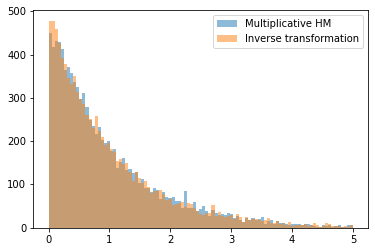

In [124]:
#For an exponential distribution of mean 1
def density_exponential(x):
    if (x < 20 and x > 0): #The 20 is there to avoid overflows
        return np.exp(-x)
    else:
        return 0.

n_samples = 10000

HM_samples = []
inverse_tr_samples = []

for _ in range(n_samples):
    HM_samples.append(multiplicative_HM_sampling(density=density_exponential,maxIter=40,X0=1))
    
    #The inverse transform is given by X = -log(U) where U is uniform on [0.1]
    inverse_tr_samples.append(-np.log(np.random.uniform()))

bins = np.linspace(0, 5, 100)

plt.hist(HM_samples, bins, alpha=0.5, label='Multiplicative HM')
plt.hist(inverse_tr_samples, bins, alpha=0.5, label='Inverse transformation')
plt.legend()
plt.show()

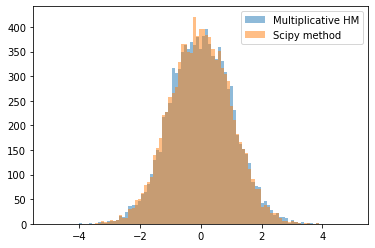

In [71]:
#For a gaussian of mean 0 and variance 1
n_samples = 10000

HM_samples = []
sp_samples = []

for _ in range(n_samples):
    HM_samples.append(multiplicative_HM_sampling(density=sp.norm(loc=0,scale=1).pdf,maxIter=20,X0=1))
    sp_samples.append(sp.norm(loc=0,scale=1).rvs(size=None))

bins = np.linspace(-5, 5, 100)

plt.hist(HM_samples, bins, alpha=0.5, label='Multiplicative HM')
plt.hist(sp_samples, bins, alpha=0.5, label='Scipy method')
plt.legend()
plt.show()

4) The distribution obtained by Multiplicative HM Sampling matches closely the real distribution, but it needs a high value for maxIter and is extremely computationally costly, even if considerably less so than with a gaussian proposal.